# Algorithm Practice
#### Goal is to use several simple sklearn algorithms to practice comparing:
- Model Performance
- ROC Curves
- Permutation Importance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_path = os.path.join("..","..","data","train.csv"); csv_path_test = os.path.join("..","..","data","test.csv")
train_data = pd.read_csv(csv_path); test_data = pd.read_csv(csv_path_test)

In [3]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## Are there any NA values? ANS: No

In [4]:
# Check for null values
train_data.isnull().values.any()

False

## What is the metadata? Can memory be reduced at all?

In [5]:
print(f"Datatype of target: {train_data.target.dtype}")
print(f"Datatype of variables: {train_data.var_0.dtype}")

Datatype of target: int64
Datatype of variables: float64


In [6]:
# Can modify dataype of these to int8 and float32 respectedly
train_data.target = train_data.target.astype(np.int8)
for col in train_data.iloc[:,2:].columns:
    train_data[col] = train_data[col].astype(np.float32)

print(f"New Datatype of target: {train_data.target.dtype}")
print(f"New Datatype of variables: {train_data.var_0.dtype}")

New Datatype of target: int8
New Datatype of variables: float32


In [7]:
# Print new memory usage:
mem_usg = train_data.memory_usage().sum() / 1024**2 
print("Memory usage is: ",mem_usg," MB")

Memory usage is:  154.30458068847656  MB


### Revisit the imbalance in Data

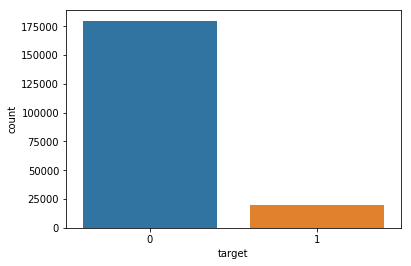

In [8]:
sns.countplot(x="target", data=train_data)
plt.show()

<hr>

## Algorithms to be used:
- LogisticRegression
- K Nearest Neighbors
- Decision Tree
- Random Forest
- SVM Linear
- SVM RBF
- SGDRegressor
- LightGBM (Seperate package... import lightgbm ias lgb)

In [9]:
# from sklearn.model_selection import train_test_split

# X = train_data.drop(columns=["ID_code","target"])
# y = train_data.target

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
# print(f"Train shape: {X_train.shape}")
# print(f"Test shape: {X_test.shape}")

### Start with LogisticRegression

In [11]:
# from sklearn.linear_model import LogisticRegression

# # Model Creation
# # C: Like in support vector machines, smaller values specify stronger regularization.
# logmodel = LogisticRegression(C=0.001, class_weight="balanced")

# # fit the model to training data
# logmodel.fit(X_train, y_train)

# # Predict target values
# predictions = logmodel.predict_proba(X_test)[:,1]

# # Print the score of the fitted model
# print(logmodel.score(X_test, y_test))

### Looks like the model performed decently despite the imbalance in data
Lets look at the ROC curve

In [12]:
# from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# # Create ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
# AUC = auc(fpr, tpr)

# print()
# print(f"Area Under the Curve Score: {AUC}")

# # Create Plot... Using seaborn plot takes longer to execute

# sns.set_style("darkgrid")

# fig, ax = plt.subplots(figsize=(20,10))
# sns.lineplot(x=fpr, y=tpr, ax=ax, color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=ax, color="red")
# ax.lines[1].set_linestyle("--")

# plt.show()

### The ROC Curve looks decent, but lets compare to the percision recall curve

In [13]:
# # Create PRC Curve
# p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))

# # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# # ROC Curve
# sns.lineplot(x=fpr, y=tpr, ax=axes[0], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=axes[0], color="red")
# axes[0].lines[1].set_linestyle("--")
# axes[0].set_ylim([-0.05, 1.05])
# axes[0].set_xlim([-0.05, 1.05])
# axes[0].set_title("ROC Curve")
# axes[0].set_xlabel("")
# axes[0].set_ylabel("")

# # PRC
# sns.lineplot(x=p, y=r, ax=axes[1], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[1,0], ax=axes[1], color="red")
# axes[1].lines[1].set_linestyle("--")
# axes[1].set_ylim([-0.05, 1.05])
# axes[1].set_xlim([-0.05, 1.05])
# axes[1].set_title("Percision Recall Curve")
# axes[1].set_xlabel("")
# axes[1].set_ylabel("")


In [14]:
# print(classification_report(y_test, logmodel.predict(X_test)))

## Observation notes:
- ROC Curve looks decent here because ROC curve does not punish for low False Positive Rate because there are so many negatives
- Precision is highly sensitive to false positives. PR curve should tend toward the top right for good models.

https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

## What if we used a StandardScaler()?

In [15]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train); X_test_scaled = scaler.transform(X_test)

### Put it all together:

In [16]:
# # Model Creation
# # C: Like in support vector machines, smaller values specify stronger regularization.
# logmodel = LogisticRegression(C=0.001, class_weight="balanced")

# # fit the model to training data
# logmodel.fit(X_train_scaled, y_train)

# # Predict target values
# predictions_scaled = logmodel.predict_proba(X_test_scaled)[:,1]

# # Print the score of the fitted model
# print(logmodel.score(X_test_scaled, y_test))

In [17]:
# # Create ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions_scaled.reshape(-1,1))
# AUC = auc(fpr, tpr)

# print()
# print(f"Area Under the Curve Score: {AUC}")

# # Create PRC Curve
# p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions_scaled.reshape(-1,1))

# # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# # ROC Curve
# sns.lineplot(x=fpr, y=tpr, ax=axes[0], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[0,1], ax=axes[0], color="red")
# axes[0].lines[1].set_linestyle("--")
# axes[0].set_ylim([-0.05, 1.05])
# axes[0].set_xlim([-0.05, 1.05])
# axes[0].set_title("ROC Curve")
# axes[0].set_xlabel("")
# axes[0].set_ylabel("")

# # PRC
# sns.lineplot(x=p, y=r, ax=axes[1], color="blue", label="Logistic")
# sns.lineplot(x=[0,1], y=[1,0], ax=axes[1], color="red")
# axes[1].lines[1].set_linestyle("--")
# axes[1].set_ylim([-0.05, 1.05])
# axes[1].set_xlim([-0.05, 1.05])
# axes[1].set_title("Percision Recall Curve")
# axes[1].set_xlabel("")
# axes[1].set_ylabel("")

# plt.show()

In [18]:
# print(classification_report(y_test, logmodel.predict(X_test_scaled)))

### There's no noticable difference between scaling and not scaling!

<hr>

## Define Plotting function to produce comparison ROC Curve and PR Curve Charts! 

In [19]:
def ROC_PR_Curves(y_test, algo_dict):
    # Creates the ROC vs. PC Curve chart above after all the models have been calculated and stored in algo_dict
    # algo_dict ex: {"Logistic_Regression": log_predictions, "KNN": knn_predictions, ...}
    
    # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        
    for label, predictions in algo_dict.items():
        
        # Create ROC curve
        fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        AUC = np.round(auc(fpr, tpr), 4)
        sns.lineplot(x=fpr, y=tpr, ax=axes[0], label=f"{label} - AUC Score: {AUC}")

        # Create PR Curve
        p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        sns.lineplot(x=p, y=r, ax=axes[1], label=label)
    
    # ROC Curve Axes Parameters
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_title("ROC Curve")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")        
    
    # PR Curve Axes Parameters
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_title("Percision Recall Curve")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    # Display the Plot
    plt.show()
    
    return "Finished"

## Now that ROC_PR_Curve is available:
- Try all 8 algorithms
- Add results of predict_proba to algo_dict

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

X = train_data.drop(columns=["ID_code","target"])
y = train_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
# Define algo_dict
algo_dict = {}

### LogisticRegression

In [22]:
# Import model
from sklearn.linear_model import LogisticRegression

# Fit and calculate predictions to the model
logmodel = LogisticRegression(C=0.001, class_weight="balanced")
logmodel.fit(X_train, y_train)
predictions = logmodel.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["LogisticRegression"] = predictions

# print the score
print(logmodel.score(X_test, y_test))
print()
print(classification_report(y_test, logmodel.predict(X_test)))

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7794

              precision    recall  f1-score   support

           0       0.97      0.78      0.86     53966
           1       0.28      0.76      0.41      6034

   micro avg       0.78      0.78      0.78     60000
   macro avg       0.62      0.77      0.64     60000
weighted avg       0.90      0.78      0.82     60000



### KNN - May try multiple k values. For now try 3.
#### Takes too long to run... will not be using this model

In [23]:
# # Import Model
# from sklearn.neighbors import KNeighborsClassifier

# # Fit and calculate predictions to the model
# neigh = KNeighborsClassifier(n_neighbors=3, weights="uniform")
# neigh.fit(X_train, y_train)
# predictions = neigh.predict_proba(X_test)[:,1]

# # Move predictions to algo_dict
# algo_dict["KNN_n=3"] = predictions

# # print the score
# print(neigh.score(X_test, y_test))
# print()
# print(classification_report(y_test, neigh.predict(X_test)))

### Decision Tree

In [24]:
# Import Model
from sklearn.tree import DecisionTreeClassifier

# Fit and calculate predictions to the model
dtree = DecisionTreeClassifier(class_weight="balanced")
dtree.fit(X_train, y_train)
predictions = dtree.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["DecisionTree"] = predictions

# print the score
print(dtree.score(X_test, y_test))
print()
print(classification_report(y_test, dtree.predict(X_test)))

0.8267166666666667

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     53966
           1       0.16      0.17      0.16      6034

   micro avg       0.83      0.83      0.83     60000
   macro avg       0.53      0.53      0.53     60000
weighted avg       0.83      0.83      0.83     60000



### Random Forest - for now lets use 15 trees.

In [25]:
# Import Model
from sklearn.ensemble import RandomForestClassifier

# Fit and calculate predictions to the model
rforest = RandomForestClassifier(n_estimators=15, class_weight="balanced")
rforest.fit(X_train, y_train)
predictions = rforest.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["RandomForect_N15"] = predictions

# print the score
print(rforest.score(X_test, y_test))
print()
print(classification_report(y_test, rforest.predict(X_test)))

0.8995666666666666

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     53966
           1       0.68      0.00      0.00      6034

   micro avg       0.90      0.90      0.90     60000
   macro avg       0.79      0.50      0.48     60000
weighted avg       0.88      0.90      0.85     60000



## Plot all models on a ROC Curve and PR Curve:

C:\Users\mtoriello0725\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


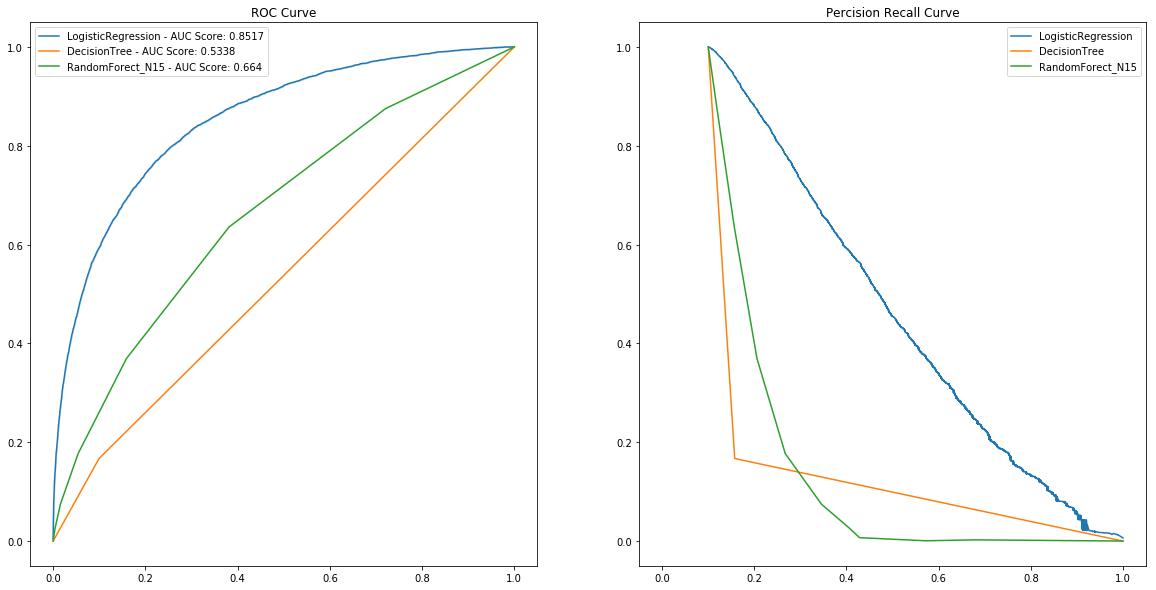

'Finished'

In [26]:
ROC_PR_Curves(y_test=y_test, algo_dict=algo_dict)